
# This notebook used on a blocksync object to verify recording synchronization and TTL mapping of the RPI eye videos

In [13]:
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs

In [2]:
block_numbers = [1]
bad_blocks = [] #
experiment_path = pathlib.Path(r"X:\Nimrod\synctrial")
animal = 'test_007'

block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks,regev=True,
                                      )
for block in block_collection:
    block.channeldict = None
    block.channeldict={1: 'LED_driver',
                       8: 'L_eye_TTL',
                       2: 'Arena_TTL',
                       7: 'R_eye_TTL'}
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 001 at Path: X:\Nimrod\synctrial\test_007\2025_08_05\block_001, new OE version
Found the sample rate for block 001 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 001
got it!


In [3]:
block.handle_eye_videos()
block.parse_open_ephys_events()


handling eye video files
converting videos...
converting files: ['X:\\Nimrod\\synctrial\\test_007\\2025_08_05\\block_001\\eye_videos\\LE\\synctrial2\\synctrial2.h264', 'X:\\Nimrod\\synctrial\\test_007\\2025_08_05\\block_001\\eye_videos\\RE\\synctrial2\\synctrial2.h264'] 
 avoiding conversion on files: ['X:\\Nimrod\\synctrial\\test_007\\2025_08_05\\block_001\\eye_videos\\LE\\synctrial2\\synctrial2_LE.mp4', 'X:\\Nimrod\\synctrial\\test_007\\2025_08_05\\block_001\\eye_videos\\RE\\synctrial2\\synctrial2.mp4']
The file X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\RE\synctrial2\synctrial2.mp4 already exists, no conversion necessary
Validating videos...
The video named synctrial2_LE.mp4 has reported 22669 frames and has 22669 frames, it has dropped 0 frames
The video named synctrial2.mp4 has reported 22681 frames and has 22681 frames, it has dropped 0 frames
running parse_open_ephys_events...
block 001 has a parsed events file, reading...


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def make_events_timeseries(events_csv_path, channeldict, sample_rate):
    """
    Reads an Open Ephys `events.csv` (with columns 'line', 'state', 'sample_number'),
    extracts rising edges (state==1), and for each channel in channeldict returns
    a DataFrame with:
        ms_timestamp : timestamp in milliseconds (relative to first event)
        frame_num    : 0-based event index for that channel
    Returns:
        dict mapping channel_name → DataFrame(ms_timestamp, frame_num)
    """
    # 1. load & keep only rising edges
    df = pd.read_csv(events_csv_path)
    df_on = df[df['state'] == 1].copy()

    ts_dict = {}
    for line_id, chan_name in channeldict.items():
        sel = df_on[df_on['line'] == line_id]
        samples = sel['sample_number'].to_numpy(dtype=float)
        # convert to ms
        ms = samples * 1000.0 / sample_rate
        # make relative to first event
        ms_rel = ms - ms[0]
        frames = np.arange(len(ms_rel), dtype=int)

        ts = pd.DataFrame({
            'ms_timestamp': ms_rel,
            'frame_num':    frames
        })
        ts_dict[chan_name] = ts

    return ts_dict


def make_video_timeseries(video_ts_csv, timestamp_col=None):
    """
    Reads a video timestamp CSV and returns a DataFrame with:
        ms_timestamp : timestamp in milliseconds (relative to first frame)
        frame_num    : 0-based frame index
    Assumes the file has exactly one column of timestamps (in seconds).
    If `timestamp_col` is given, uses that column name; otherwise:
      • if 'time_sec' exists, uses it
      • else takes the first column.
    """
    df = pd.read_csv(video_ts_csv)
    # pick the timestamps column
    if timestamp_col and timestamp_col in df.columns:
        t_sec = df[timestamp_col]
    elif 'time_sec' in df.columns:
        t_sec = df['time_sec']
    else:
        t_sec = df.iloc[:, 0]

    ms = t_sec.to_numpy(dtype=float) * 1000.0
    ms_rel = ms - ms[0]
    frames = np.arange(len(ms_rel), dtype=int)

    return pd.DataFrame({
        'ms_timestamp': ms_rel,
        'frame_num':    frames
    })


def compare_timeseries(ts_events, ts_video, plot=True):
    """
    Given two DataFrames (each with 'ms_timestamp' and 'frame_num'),
    computes and returns a dict with:
      - count_events, count_video, count_diff
      - IEI distributions: iei_events, iei_video
      - matched timing differences (video - events)
      - summary stats: mean_diff_ms, std_diff_ms

    If plot=True, also shows:
      1) histogram of IEIs for each series
      2) matched-diffs vs. event index
    """
    # 1. align both to zero
    ev = ts_events['ms_timestamp'].to_numpy()
    vid = ts_video['ms_timestamp'].to_numpy()

    n_ev  = len(ev)
    n_vid = len(vid)

    iei_ev  = np.diff(ev)
    iei_vid = np.diff(vid)

    # 2. pair up to the shorter length
    n_match = min(n_ev, n_vid)
    diffs = vid[:n_match] - ev[:n_match]

    report = {
        'count_events': n_ev,
        'count_video':  n_vid,
        'count_diff':   n_vid - n_ev,
        'iei_events':   iei_ev,
        'iei_video':    iei_vid,
        'matched_diffs': diffs,
        'mean_diff_ms': np.mean(diffs),
        'std_diff_ms':  np.std(diffs),
    }

    if plot:
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))

        axs[0].hist(iei_ev,  bins=50, alpha=0.6, label='events IEI')
        axs[0].hist(iei_vid, bins=50, alpha=0.6, label='video  IEI')
        axs[0].set_xlabel('inter-event interval (ms)')
        axs[0].legend()

        axs[1].plot(diffs, marker='.', linestyle='none')
        axs[1].axhline(report['mean_diff_ms'], color='r', label=f"mean Δ={report['mean_diff_ms']:.2f} ms")
        axs[1].set_xlabel('event index')
        axs[1].set_ylabel('video – events (ms)')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    return report


In [6]:
# 1) sample rate from your BlockSync instance
sr = block.sample_rate   # e.g. 30000.0

# 2) turn events.csv → per-channel timeseries
chdict = {1:'LED_driver', 8:'L_eye_TTL', 2:'Arena_TTL', 7:'R_eye_TTL'}
ts_dict = make_events_timeseries(str(block.block_path/'oe_files'/block.oe_dirname/'events.csv'),
                                 chdict,
                                 sample_rate=sr)

# 3) turn your three video PC files → timeseries
ts_L = make_video_timeseries(r'X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\LE\synctrial2\synctrial2_timestamps.csv')
ts_R = make_video_timeseries(r'X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\RE\synctrial2\synctrial2_timestamps.csv')
ts_A = make_video_timeseries(r'X:\Nimrod\synctrial\test_007\2025_08_05\block_001\arena_videos\videos\frames_timestamps\top_20250805T130753.csv')

In [21]:
import datetime
import pathlib
import numpy as np
import matplotlib.pyplot as plt

# Friendly PDF text rendering (editable fonts in Illustrator)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

def compare_timeseries(ts_events,
                       ts_video,
                       plot=True,
                       export_path=None,
                       title=None,
                       labels=('events IEI','video IEI'),
                       bins=50):
    """
    Compare two time series with 'ms_timestamp' and 'frame_num' columns.

    Returns a dict with:
      - count_events, count_video, count_diff
      - iei_events (ms), iei_video (ms)
      - matched_diffs (ms) = video_ms[:n] - events_ms[:n]
      - mean_diff_ms, std_diff_ms

    Parameters
    ----------
    ts_events : pd.DataFrame
        Must contain 'ms_timestamp' (milliseconds) and 'frame_num'.
    ts_video : pd.DataFrame
        Must contain 'ms_timestamp' (milliseconds) and 'frame_num'.
    plot : bool
        If True, show the figure. If False, no UI show.
        NOTE: If export_path is provided, a figure will be created and saved
        regardless of plot.
    export_path : str or Path or None
        If provided, saves a PDF to a timestamped folder:
        <export_path>/<YYYYMMDDTHHMMSS>_compare_timeseries/compare_<labelA>_vs_<labelB>.pdf
    title : str or None
        Optional suptitle for the figure.
    labels : tuple(str, str)
        Legend labels for IEI histograms (events label, video label).
        Also used in the filename.
    bins : int
        Histogram bins for the IEI plots.
    """
    # --- data prep ---
    ev = np.asarray(ts_events['ms_timestamp'].to_numpy(), dtype=float)
    vid = np.asarray(ts_video['ms_timestamp'].to_numpy(), dtype=float)

    n_ev  = int(len(ev))
    n_vid = int(len(vid))

    if n_ev < 2 or n_vid < 2:
        raise ValueError("Both series must have at least 2 timestamps to compute IEIs.")

    iei_ev  = np.diff(ev)
    iei_vid = np.diff(vid)

    # match to shorter length for jitter diffs
    n_match = int(min(n_ev, n_vid))
    diffs   = vid[:n_match] - ev[:n_match]

    report = {
        'count_events': n_ev,
        'count_video':  n_vid,
        'count_diff':   n_vid - n_ev,
        'iei_events':   iei_ev,
        'iei_video':    iei_vid,
        'matched_diffs': diffs,
        'mean_diff_ms': float(np.mean(diffs)),
        'std_diff_ms':  float(np.std(diffs)),
    }

    # --- decide whether we need to build a figure ---
    need_figure = bool(plot or export_path is not None)

    fig = None
    axs = None

    if need_figure:
        fig, axs = plt.subplots(2, 1, figsize=(8, 5))

        # IEI histograms
        axs[0].hist(iei_ev,  bins=bins, alpha=0.65, label=labels[0])
        axs[0].hist(iei_vid, bins=bins, alpha=0.65, label=labels[1])
        axs[0].set_xlabel('Inter-event interval (ms)')
        axs[0].set_ylabel('Count')
        axs[0].legend(loc='best')
        axs[0].set_title('IEI Distributions')

        # matched diffs scatter
        axs[1].plot(diffs, marker='.', linestyle='none')
        axs[1].axhline(report['mean_diff_ms'], color='r', linewidth=1.2,
                       label="mean Δ = {:.2f} ms".format(report['mean_diff_ms']))
        axs[1].set_xlabel('Matched index')
        axs[1].set_ylabel('Video – Events (ms)')
        axs[1].legend(loc='best')
        axs[1].set_title('Per-match timing differences')

        # Optional super title with a concise summary
        if title is None:
            title = (f"Counts: events={n_ev}, video={n_vid} "
                     f"| mean Δ = {report['mean_diff_ms']:.2f} ms ± {report['std_diff_ms']:.2f} ms")
        fig.suptitle(title, y=1.02, fontsize=12)

        fig.tight_layout()

        # --- export if requested ---
        if export_path is not None:
            base = pathlib.Path(export_path)
            stamp = datetime.datetime.now().strftime('%Y%m%dT%H%M%S')
            out_dir = base / f"{stamp}_compare_timeseries"
            out_dir.mkdir(parents=True, exist_ok=True)

            # sanitize filename pieces (avoid spaces/slashes)
            def _clean(s):
                return "".join(c if c.isalnum() or c in ('-', '_') else '_' for c in str(s))

            fname = f"compare_{_clean(labels[0])}_vs_{_clean(labels[1])}.pdf"
            pdf_path = out_dir / fname

            # Save vector PDF
            fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
            # You could also save a lightweight PNG preview if you want:
            # fig.savefig(out_dir / fname.replace('.pdf', '.png'), dpi=200, bbox_inches='tight')

        # show or close depending on 'plot'
        if plot:
            plt.show()
        else:
            plt.close(fig)

    return report if not need_figure else (report, fig, axs)


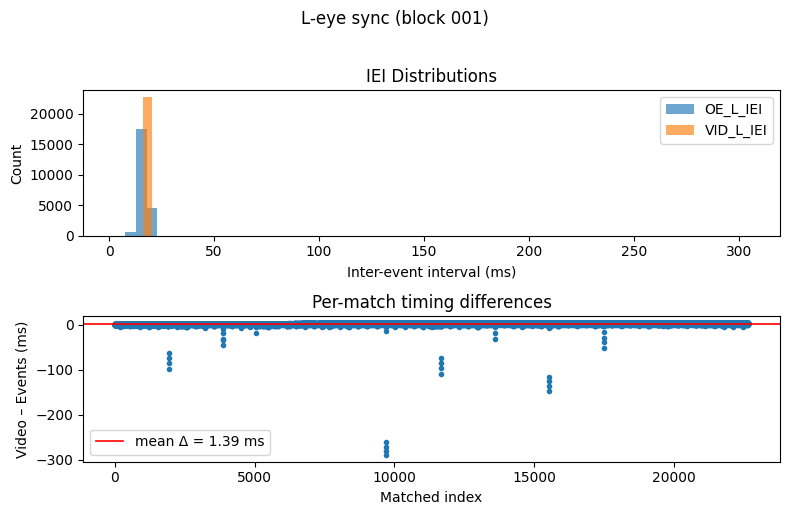

mean jitter: 1.39 ms ± 4.66 ms


In [22]:
# Compare L-eye OE vs L video, export a PDF to your analysis folder:
report_L, fig, axs = compare_timeseries(
    ts_dict['L_eye_TTL'], ts_L,
    plot=True,
    export_path=block.analysis_path,  # or any folder you prefer
    title=f"L-eye sync (block {block.block_num})",
    labels=('OE_L_IEI','VID_L_IEI'),
    bins=60
)
print(f"mean jitter: {report_L['mean_diff_ms']:.2f} ms ± {report_L['std_diff_ms']:.2f} ms")


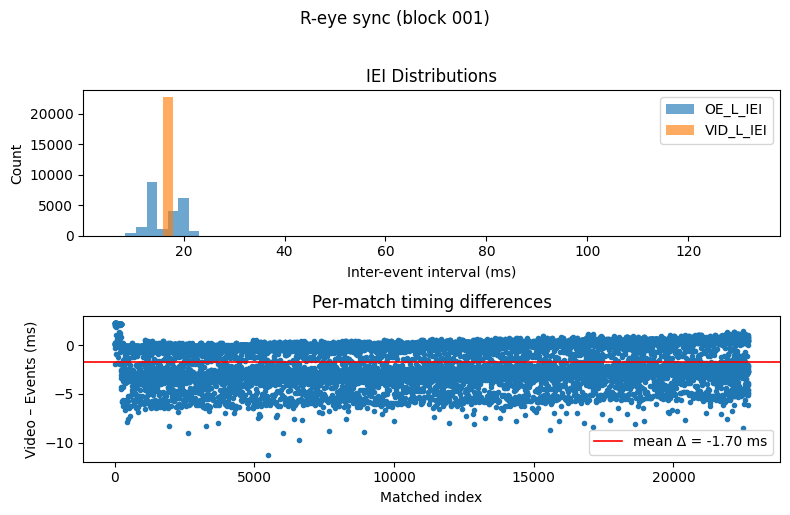

mean jitter: -1.70 ms ± 1.76 ms


In [23]:
# Compare R-eye OE vs R  video, export a PDF to your analysis folder:
report_L, fig, axs = compare_timeseries(
    ts_dict['R_eye_TTL'], ts_R,
    plot=True,
    export_path=block.analysis_path,  # or any folder you prefer
    title=f"R-eye sync (block {block.block_num})",
    labels=('OE_L_IEI','VID_L_IEI'),
    bins=60
)
print(f"mean jitter: {report_L['mean_diff_ms']:.2f} ms ± {report_L['std_diff_ms']:.2f} ms")

In [17]:
block.analysis_path

WindowsPath('X:/Nimrod/synctrial/test_007/2025_08_05/block_001/analysis')

In [5]:


# 4) compare any pair, e.g. L-eye vs. its OE events:
report_L = compare_timeseries(ts_dict['L_eye_TTL'], ts_L)

# 5) inspect
print(report_L['count_events'], report_L['count_video'], report_L['count_diff'])
print(f"mean jitter: {report_L['mean_diff_ms']:.2f} ms ± {report_L['std_diff_ms']:.2f} ms")


NameError: name 'ts_dict' is not defined

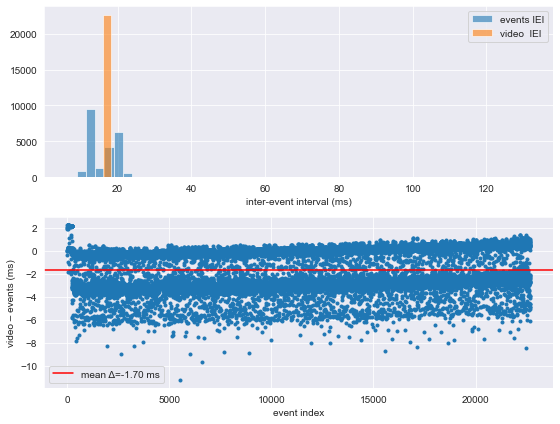

22681 22681 0
mean jitter: -1.70 ms ± 1.76 ms


In [10]:
report_R = compare_timeseries(ts_dict['R_eye_TTL'], ts_R)
print(report_R['count_events'], report_R['count_video'], report_R['count_diff'])
print(f"mean jitter: {report_R['mean_diff_ms']:.2f} ms ± {report_R['std_diff_ms']:.2f} ms")

In [ ]:
# -- prepare your OE timeseries for one channel, e.g. 'L_eye_TTL' --
ts_dict = make_events_timeseries(
    str(block.block_path/'oe_files'/block.oe_dirname/'events.csv'),
    block.channeldict,
    sample_rate=block.sample_rate
)
oe_L = ts_dict['L_eye_TTL']

# -- then launch the interactive GUI for left‐eye sync checking --
interactive_sync_verification(
    video_path='/path/to/left_eye_video.mp4',
    oe_ts=oe_L,
    video_ts_csv='/path/to/left_eye_timestamps.csv'
)


In [13]:
ts_dict.keys()
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import pathlib
from tqdm import tqdm

def synchronize_block_for_non_60fps_acquisition(self, export=True, overwrite=False, target_frame_rate=60, margin_of_error=0.1):
    """
    Synchronize the video frames to a target frame rate using interpolation.
    """
    # Check if previously exported file exists
    if pathlib.Path(self.analysis_path / 'blocksync_df.csv').exists() and not overwrite:
        self.blocksync_df = pd.read_csv(pathlib.Path(self.analysis_path / 'blocksync_df.csv'), engine='python')
        print('blocksync_df loaded from analysis folder')
        return self.blocksync_df

    print('Creating blocksync_df')

    # Define start and end times
    start_time = max([self.arena_vid_first_t, self.r_vid_first_t, self.l_vid_first_t])
    end_time = min([self.arena_vid_last_t, self.r_vid_last_t, self.l_vid_last_t])

    # Extract TTLs and calculate frame rate
    arena_ttls = self.oe_events.query('@start_time < Arena_TTL < @end_time')['Arena_TTL'].values
    arena_frame_rate = self.sample_rate / np.median(np.diff(arena_ttls))

    if not (target_frame_rate - margin_of_error <= arena_frame_rate <= target_frame_rate + margin_of_error):
        print(f"Arena video frame rate is {arena_frame_rate:.2f} Hz. Adjusting to {target_frame_rate} FPS.")

        # Define target time base
        original_time = np.cumsum(np.insert(np.diff(arena_ttls), 0, 0)) / self.sample_rate
        target_time = np.arange(0, original_time[-1], 1 / target_frame_rate)

        # Interpolate using linear method
        interpolator = interp1d(original_time, arena_ttls, kind='linear', fill_value='extrapolate')
        new_arena_ttl = interpolator(target_time).astype(int)
    else:
        print(f"Arena video frame rate is {arena_frame_rate:.2f} Hz, within acceptable range. No adjustment needed.")
        new_arena_ttl = arena_ttls

    # Create a synchronization DataFrame
    arena_tf = self.oe_events.query('@start_time < Arena_TTL < @end_time')[['Arena_TTL', 'Arena_TTL_frame']]
    r_eye_tf = self.oe_events.query('@start_time < Arena_TTL < @end_time or Arena_TTL != Arena_TTL')[['R_eye_TTL', 'R_eye_TTL_frame']].dropna()
    l_eye_tf = self.oe_events.query('@start_time < Arena_TTL < @end_time or Arena_TTL != Arena_TTL')[['L_eye_TTL', 'L_eye_TTL_frame']].dropna()

    # Build the synchronization DataFrame
    self.blocksync_df = pd.DataFrame(columns=['Arena_frame', 'L_eye_frame', 'R_eye_frame'], index=new_arena_ttl)

    for t in tqdm(new_arena_ttl, desc='Synchronizing Frames'):
        arena_frame = arena_tf['Arena_TTL_frame'].iloc[self.get_closest_frame(t, arena_tf['Arena_TTL'])]
        l_eye_frame = l_eye_tf['L_eye_TTL_frame'].iloc[self.get_closest_frame(t, l_eye_tf['L_eye_TTL'])]
        r_eye_frame = r_eye_tf['R_eye_TTL_frame'].iloc[self.get_closest_frame(t, r_eye_tf['R_eye_TTL'])]
        self.blocksync_df.loc[t] = [arena_frame, l_eye_frame, r_eye_frame]

    print('Created blocksync_df')
    if export:
        self.blocksync_df.to_csv(self.analysis_path / 'blocksync_df.csv')
        print(f'Exported blocksync_df to {self.analysis_path}/blocksync_df.csv')

    return self.blocksync_df


In [14]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.handle_arena_files()
    block.parse_open_ephys_events()
    block.handle_eye_videos()
    block.get_eye_brightness_vectors()
#    block.synchronize_block()
    block.synchronize_block_for_non_60fps_acquisition(export=True,
                                                      overwrite=False,
                                                      target_frame_rate=60,
                                                      margin_of_error=5)
    block.create_eye_brightness_df(threshold_value=20)

handling arena files
Arena video Names:
front_20250805T130753.mp4
left_20250805T130753.mp4
right_20250805T130753.mp4
top_20250805T130753.mp4
running parse_open_ephys_events...
block 001 has a parsed events file, reading...
handling eye video files
converting videos...
converting files: ['X:\\Nimrod\\synctrial\\test_007\\2025_08_05\\block_001\\eye_videos\\LE\\synctrial2\\synctrial2.h264', 'X:\\Nimrod\\synctrial\\test_007\\2025_08_05\\block_001\\eye_videos\\RE\\synctrial2\\synctrial2.h264'] 
 avoiding conversion on files: ['X:\\Nimrod\\synctrial\\test_007\\2025_08_05\\block_001\\eye_videos\\LE\\synctrial2\\synctrial2_LE.mp4', 'X:\\Nimrod\\synctrial\\test_007\\2025_08_05\\block_001\\eye_videos\\RE\\synctrial2\\synctrial2.mp4']
The file X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\RE\synctrial2\synctrial2.mp4 already exists, no conversion necessary
Validating videos...
The video named synctrial2_LE.mp4 has reported 22669 frames and has 22669 frames, it has dropped 0 frames


Processing X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\LE\synctrial2\synctrial2_LE.mp4:   1%|          | 157/22669 [00:00<00:14, 1568.80frame/s]

Working on video X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\LE\synctrial2\synctrial2_LE.mp4


Processing X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\LE\synctrial2\synctrial2_LE.mp4: 100%|██████████| 22669/22669 [00:11<00:00, 1982.22frame/s]
Processing X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\RE\synctrial2\synctrial2.mp4:   1%|          | 175/22681 [00:00<00:12, 1742.39frame/s]

Finished video X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\LE\synctrial2\synctrial2_LE.mp4, processed 22669 frames
Working on video X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\RE\synctrial2\synctrial2.mp4


Processing X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\RE\synctrial2\synctrial2.mp4: 100%|██████████| 22681/22681 [00:10<00:00, 2063.78frame/s]
  0%|          | 0/21489 [00:00<?, ?it/s]

Finished video X:\Nimrod\synctrial\test_007\2025_08_05\block_001\eye_videos\RE\synctrial2\synctrial2.mp4, processed 22681 frames
Eye brightness vectors generation complete.
creating blocksync_df
Arena video frame rate is 59.17 Hz, within acceptable range. No adjustment needed.


100%|██████████| 21489/21489 [00:03<00:00, 5883.06it/s]


created blocksync_df
exported blocksync_df to X:\Nimrod\synctrial\test_007\2025_08_05\block_001\analysis/ blocksync_df.csv
creating X:\Nimrod\synctrial\test_007\2025_08_05\block_001\analysis/eye_brightness_df.csv


In [17]:
block.get_eyes_diff_list(2)

index error on position 16 out of 17
index error on position 19 out of 20
The suspected lag between eye cameras is 18.0 with the direction ['right', 'late']


In [18]:
block.fix_eye_synchronization()

created manual_sync_df attribute for the block


In [19]:
def full_sync_verification(self):
    from bokeh.plotting import figure, show, curdoc
    from bokeh.models import Slider, ColumnDataSource, CustomJS
    from bokeh.layouts import column
    import numpy as np
    data_dict = {
    'L_values': [None if np.isnan(x) or np.isinf(x) else x for x in
    self.manual_sync_df['L_values']],
    'R_values': [None if np.isnan(x) or np.isinf(x) else x for x in
    self.manual_sync_df['R_values']]
    }
    source = ColumnDataSource(data=dict(
    x_axis=self.manual_sync_df.index / self.sample_rate,
    left_y=[None if np.isnan(x) or np.isinf(x) else x for x in
    self.manual_sync_df['L_values'].shift(0)],
    right_y=[None if np.isnan(x) or np.isinf(x) else x for x in
    self.manual_sync_df['R_values'].shift(0)]
    ))
    bokeh_fig = figure(
    title=f'Full Synchronization Verification',
    x_axis_label='Seconds',
    y_axis_label='Brightness Z_Score',
    plot_width=1500,
    plot_height=700
    )
    left_line = bokeh_fig.line('x_axis', 'left_y', source=source,
    legend_label='Left_eye_values', line_width=1,
    line_color='blue')
    right_line = bokeh_fig.line('x_axis', 'right_y', source=source,
    legend_label='Right_eye_values', line_width=1,
    line_color='red')
    slider_left = Slider(start=-50, end=50, value=0, step=1, title="Left Eye Shift")
    slider_right = Slider(start=-50, end=50, value=0, step=1, title="Right Eye Shift")
    callback = CustomJS(args=dict(source=source, slider_left=slider_left,
    slider_right=slider_right, data_dict=data_dict),
    code="""
    const plot_data = source.data;
    const left_shift = slider_left.value;
    const right_shift = slider_right.value;
    const left_values = data_dict['L_values'];
    const right_values = data_dict['R_values'];
    const length = plot_data['x_axis'].length;
    for (let i = 0; i < length; i++) {
    plot_data['left_y'][i] = (i + left_shift >= 0 && i +
    left_shift < length) ? left_values[i + left_shift] : null;
    plot_data['right_y'][i] = (i + right_shift >= 0 && i +
    right_shift < length) ? right_values[i + right_shift] : null;
    }
    console.log("Left shift: ", left_shift, "Right shift: ",
    right_shift); // Debug output
    source.change.emit();
    """)
    slider_left.js_on_change('value', callback)
    slider_right.js_on_change('value', callback)
    layout = column(bokeh_fig, slider_left, slider_right)
    curdoc().add_root(layout)
    show(layout)

In [26]:
full_sync_verification(block)

In [23]:
block.manual_sync_df

,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
Arena_TTL,,,,,
517409.0,272,0,23,5.531620,-0.844745
517747.0,273,1,24,5.641008,-0.895167
518085.0,274,2,25,6.238871,-0.898901
518424.0,275,3,26,6.224128,-0.863281
518762.0,276,4,27,0.459562,-0.852422
...,...,...,...,...,...
7781565.0,21756,22662,NaN,0.305233,NaN
7781903.0,21757,22663,NaN,0.289121,NaN
7782241.0,21758,22664,NaN,0.280812,NaN


In [27]:
# alternative sync approach: